# Outlier Detection

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from collections import deque
# import sys

from statsmodels.tsa.seasonal import seasonal_decompose, STL

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

from sklearn.metrics import (
                            roc_curve,
                            auc, accuracy_score,
                            precision_score, 
                            recall_score,
                            f1_score,
                            confusion_matrix
                            )
import tensorflow as tf
from pickle import dump
import yaml


from keras.models import Model, Sequential
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.layers import Dropout

In [131]:
# 1. Función para cargar y limpiar los datos
def cargar_y_limpiar_datos(file_path):
    data = pd.read_excel(file_path, header=0)
    data = data.drop(['Total general (Número de pasajeros)'], axis=1)
    data['Día'] = pd.to_datetime(data['Día'], dayfirst=True)
    data.columns = [str(col) if isinstance(col, datetime.time) else col for col in data.columns]
    horas = [col for col in data.columns if ':' in col]
    return data, horas

# 2. Función para filtrar datos de una línea específica
def filtrar_por_linea(data, linea_servicio='línea a'):
    return data[data['Línea de Servicio'].str.lower() == linea_servicio]

# 3. Función para generar el DataFrame completo de fechas y agregar columnas adicionales
def generar_dataframe_completo(data_linea_a, start, end):
    fechas_2023 = pd.DataFrame({'Día': pd.date_range(start=start, end=end)})
    data_linea_a_full = pd.merge(fechas_2023, data_linea_a, on='Día', how='left')
    data_linea_a_full['Día de la Semana'] = data_linea_a_full['Día'].dt.day_name()
    data_linea_a_full.columns = [str(col) if isinstance(col, datetime.time) else col for col in data_linea_a_full.columns]
    return data_linea_a_full

# 4. Función para calcular el promedio estacional por día de la semana
def calcular_promedio_estacional(data, horas):
    return data.groupby('Día de la Semana')[horas].median().round(0)

# 5. Función para rellenar los valores faltantes
def rellenar_faltantes(data, promedio_estacional, horas):
    # Asegúrate de que 'Día' esté presente en el DataFrame
    if 'Día de la Semana' not in data.columns:
        raise ValueError("El DataFrame 'data' debe contener una columna llamada 'Día' que indique el día de la semana.")

    # Itera sobre las horas para rellenar los valores faltantes
    for hora in horas:
        if hora in data.columns:
            # Rellena los valores faltantes según el promedio estacional
            data[hora] = data.apply(
                lambda row: promedio_estacional.loc[row['Día de la Semana'], hora] if pd.isnull(row[hora]) else row[hora], axis=1
            )
        else:
            print(f"La columna {hora} no existe en el DataFrame, omitiendo...")
        
    data['Línea de Servicio'] = data['Línea de Servicio'].fillna(method='ffill') 

    return data

# 6. Función para eliminar tendencia y estacionalidad con STL incluido
def eliminar_tendencia_estacionalidad(data, horas):
    descomposiciones = {}
    data = data.set_index('Día')  # Establecer el índice fuera del bucle
    
    for hora in horas:
        if hora not in data.columns:
            print(f"La columna {hora} no está presente en los datos.")
            continue
        
        serie = data[hora].dropna()
        
        # Verificar si la serie está vacía
        if serie.empty:
            print(f"La serie temporal para {hora} está vacía después de eliminar valores nulos.")
            continue
        
        mse_dict = {}
        
        # Descomposición aditiva
        try:
            descomp_aditiva = seasonal_decompose(serie, model='additive', period=7)
            residuo_aditivo = descomp_aditiva.resid.dropna()
            mse_aditivo = np.mean(np.square(residuo_aditivo))
            mse_dict['aditiva'] = mse_aditivo
        except ValueError as e:
            print(f"Error de valor en descomposición aditiva para {hora}: {e}")
            mse_dict['aditiva'] = np.inf
        except Exception as e:
            print(f"Error inesperado en descomposición aditiva para {hora}: {e}")
            mse_dict['aditiva'] = np.inf
        
        # Descomposición multiplicativa
        try:
            descomp_multiplicativa = seasonal_decompose(serie, model='multiplicative', period=7)
            residuo_multiplicativa = descomp_multiplicativa.resid.dropna()
            mse_multiplicativa = np.mean(np.square(residuo_multiplicativa))
            mse_dict['multiplicativa'] = mse_multiplicativa
        except ValueError as e:
            print(f"Error de valor en descomposición multiplicativa para {hora}: {e}")
            mse_dict['multiplicativa'] = np.inf
        except Exception as e:
            print(f"Error inesperado en descomposición multiplicativa para {hora}: {e}")
            mse_dict['multiplicativa'] = np.inf
        
        # Descomposición STL
        try:
            stl = STL(serie, period=7)
            descomp_stl = stl.fit()
            residuo_stl = descomp_stl.resid.dropna()
            mse_stl = np.mean(np.square(residuo_stl))
            mse_dict['STL'] = mse_stl
        except ValueError as e:
            print(f"Error de valor en descomposición STL para {hora}: {e}")
            mse_dict['STL'] = np.inf
        except Exception as e:
            print(f"Error inesperado en descomposición STL para {hora}: {e}")
            mse_dict['STL'] = np.inf
        
        # Selección del método con menor error
        if all(mse == np.inf for mse in mse_dict.values()):
            print(f"No se pudo realizar ninguna descomposición válida para {hora}.")
            continue
        
        metodo_min_error = min(mse_dict, key=mse_dict.get)
        if metodo_min_error == 'aditiva':
            print(f"Usando descomposición aditiva para {hora}")
            descomposiciones[hora] = descomp_aditiva
        elif metodo_min_error == 'multiplicativa':
            print(f"Usando descomposición multiplicativa para {hora}")
            descomposiciones[hora] = descomp_multiplicativa
        elif metodo_min_error == 'STL':
            print(f"Usando descomposición STL para {hora}")
            descomposiciones[hora] = descomp_stl

    return descomposiciones

# 7. Función para detectar outliers usando el método IQR
def detectar_outliers_en_residuos(descomposiciones, umbral=1.5, data=None):
    outliers_matrix = pd.DataFrame(0, index=descomposiciones[list(descomposiciones.keys())[0]].resid.dropna().index, columns=descomposiciones.keys())
    for hora, descomposicion in descomposiciones.items():
        if hora != list(descomposiciones.keys())[-1]:
            residuo = pd.DataFrame(descomposicion.resid.dropna()).merge(data, on='Día', how='left')
            residuo.index = outliers_matrix.index
            for day in data['Día de la Semana'].unique():
                residuo_estacional = residuo[residuo['Día de la Semana'] == day][hora]
                Q1 = residuo_estacional.quantile(0.25)
                Q3 = residuo_estacional.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - umbral * IQR
                upper_bound = Q3 + umbral * IQR
                outliers = ((residuo_estacional < lower_bound) | (residuo_estacional > upper_bound)).astype(int)
                outliers_matrix.loc[outliers.index, hora] = outliers

    # Columna que cuenta el número total de outliers por día
    outliers_matrix['Total_Outliers'] = outliers_matrix.sum(axis=1)
    
    # Columna que indica si existe al menos un outlier en alguna de las horas (1 si al menos uno, 0 si no) -> si hay mas de 1 (¿Una linea?, ¿Una hora influye en las demas?)
    outliers_matrix['Any_Outlier'] = (outliers_matrix['Total_Outliers'] > 0).astype(int)        
    
    return outliers_matrix

# 8. Función para graficar la proporción de días con outliers
def graficar_proporcion_outliers(data):
    proporcion_outliers = data['Hay_Outlier'].value_counts(normalize=True)
    plt.figure(figsize=(6,4))
    proporcion_outliers.plot(kind='bar', color=['blue', 'orange'], grid=True)
    plt.title('Proporción de días con al menos un outlier')
    plt.xlabel('Hay Outlier')
    plt.ylabel('Proporción')
    plt.xticks(ticks=[0, 1], labels=['No hay outliers', 'Hay al menos un outlier'], rotation=0)
    plt.ylim(0, 1)
    plt.show()


# Función para entrenar un lstm autoencoder
def entrenar_autoencoder(X_train_scaled):

    # Definir el modelo LSTM Autoencoder con capas de 128 y 64 unidades
    timesteps = X_train_scaled.shape[1]  # Número de pasos de tiempo (20)
    features = X_train_scaled.shape[2]   # Número de features (1)

    input_layer = Input(shape=(timesteps, features))

    # Encoder con Dropout
    encoded = LSTM(128, return_sequences=True)(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = LSTM(64, return_sequences=False)(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = RepeatVector(timesteps)(encoded)

    # Decoder con Dropout
    decoded = LSTM(64, return_sequences=True)(encoded)
    decoded = Dropout(0.2)(decoded)
    decoded = LSTM(128, return_sequences=True)(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = TimeDistributed(Dense(features))(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mae')

    # Implementamos Early Stopping para prevenir sobreajuste
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenar el modelo
    history = autoencoder.fit(X_train_scaled, X_train_scaled,
                            epochs=512,
                            batch_size=128,
                            validation_split=0.1,
                            shuffle=True,
                            callbacks=[early_stopping])    
    
    return autoencoder, history

# 10. Función para graficar la curva de entrenamiento
def graficar_curva_entrenamiento(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Curva de Error durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MAE)')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'./results/train_curve.png')
    plt.show()

# 11. Función para evaluar el modelo con curva ROC
def plot_roc_curve(errores_normales, errores_outliers):
    y_true = np.concatenate([np.zeros(len(errores_normales)), np.ones(len(errores_outliers))])
    y_scores = np.concatenate([errores_normales, errores_outliers])

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC para el Modelo de Detección de Anomalías')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def calcular_metricas(errores_normales, errores_outliers, umbral):
    """
    Calcula las métricas de desempeño del modelo de detección de anomalías.

    Parámetros:
    - errores_normales: array con los errores de reconstrucción de los datos normales
    - errores_outliers: array con los errores de reconstrucción de los datos con outliers
    - umbral: valor umbral para determinar si una muestra es una anomalía

    Retorna:
    - Un diccionario con las métricas: precisión, recall, F1-score, exactitud y matriz de confusión
    """
    # Crear etiquetas verdaderas: 0 para normal, 1 para anomalía
    y_true_normales = np.zeros(len(errores_normales))
    y_true_outliers = np.ones(len(errores_outliers))
    y_true = np.concatenate([y_true_normales, y_true_outliers])

    # Crear predicciones basadas en el umbral
    y_pred_normales = (errores_normales > umbral).astype(int)
    y_pred_outliers = (errores_outliers > umbral).astype(int)
    y_pred = np.concatenate([y_pred_normales, y_pred_outliers])

    # Calcular las métricas
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Crear un diccionario con las métricas
    metricas = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

    return metricas

In [132]:
# 1. Cargar y limpiar los datos para el año 2019
file_path_2019 = './data/Afluencia_Metro_2019.xlsx'
data_2019, horas_2019 = cargar_y_limpiar_datos(file_path_2019)

# 1. Cargar y limpiar los datos para el año 2020
file_path_2020 = './data/Afluencia_Metro_2020.xlsx'
data_2020, horas_2020 = cargar_y_limpiar_datos(file_path_2020)

# 1. Cargar y limpiar los datos para el año 2021
file_path_2021 = './data/Afluencia_Metro_2021.xlsx'
data_2021, horas_2021 = cargar_y_limpiar_datos(file_path_2021)

# 1. Cargar y limpiar los datos para el año 2022
file_path_2022 = './data/Afluencia_Metro_2022.xlsx'
data_2022, horas_2022 = cargar_y_limpiar_datos(file_path_2022)

# 1. Cargar y limpiar los datos para el año 2023
file_path_2023 = './data/Afluencia_Metro_2023.xlsx'
data_2023, horas_2023 = cargar_y_limpiar_datos(file_path_2023)

# 1. Cargar y limpiar los datos para el año 2024
file_path_2024 = './data/Afluencia_Metro_2024.xlsx'
data_2024, horas = cargar_y_limpiar_datos(file_path_2024)

data_2024.head()

,Día,Línea de Servicio,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2024-01-01,LÍNEA 1,180.0,858.0,886.0,721.0,659.0,820.0,952.0,1083.0,...,1418.0,1563.0,1734.0,2108.0,2352.0,1903.0,1676.0,1132.0,139.0,NaN
1,2024-01-01,LÍNEA 2,1.0,149.0,143.0,74.0,100.0,135.0,116.0,225.0,...,198.0,188.0,277.0,291.0,284.0,212.0,152.0,100.0,9.0,NaN
2,2024-01-01,LÍNEA A,1460.0,5488.0,5769.0,4752.0,3993.0,4512.0,5551.0,7197.0,...,10362.0,10666.0,12998.0,15376.0,16932.0,14537.0,11750.0,7729.0,664.0,NaN
3,2024-01-01,LÍNEA B,231.0,718.0,826.0,672.0,641.0,818.0,1060.0,1398.0,...,1741.0,1956.0,2228.0,2587.0,2749.0,2043.0,1302.0,893.0,85.0,NaN
4,2024-01-01,LÍNEA H,NaN,NaN,NaN,NaN,NaN,50.0,62.0,71.0,...,76.0,72.0,93.0,83.0,113.0,80.0,39.0,25.0,4.0,NaN


In [133]:
# 2. Filtrar los datos para la LÍNEA A en 2019
data_linea_a_2019 = filtrar_por_linea(data_2019)

# 2. Filtrar los datos para la LÍNEA A en 2020
data_linea_a_2020 = filtrar_por_linea(data_2020)

# 2. Filtrar los datos para la LÍNEA A en 2021
data_linea_a_2021 = filtrar_por_linea(data_2021)

# 2. Filtrar los datos para la LÍNEA A en 2022
data_linea_a_2022 = filtrar_por_linea(data_2022)

# 2. Filtrar los datos para la LÍNEA A en 2023
data_linea_a_2023 = filtrar_por_linea(data_2023)

# 2. Filtrar los datos para la LÍNEA A en 2024
data_linea_a_2024 = filtrar_por_linea(data_2024)
data_linea_a_2024['Línea de Servicio'].unique()

array(['LÍNEA A'], dtype=object)

In [134]:
len(data_linea_a_2019), len(data_linea_a_2020), len(data_linea_a_2021), len(data_linea_a_2022), len(data_linea_a_2023), len(data_linea_a_2024)

(365, 363, 365, 365, 365, 182)

In [135]:
# 2. Concatenar todos los dataframes de la Línea A
data_linea_a_2019_2024 = pd.concat([
                                #  data_linea_a_2019, 
                                #  data_linea_a_2020, 
                                #  data_linea_a_2021, 
                                 data_linea_a_2022, 
                                 data_linea_a_2023, 
                                 data_linea_a_2024])

# 2. Ordenar los datos por la columna "Día"
data_linea_a_2019_2024 = data_linea_a_2019_2024.sort_values(by='Día')

# Ver el resultado ordenado
data_linea_a_2019_2024.tail()

,Día,Línea de Servicio,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
2091,2024-06-26,LÍNEA A,15238.0,45356.0,62796.0,52262.0,32352.0,26201.0,23441.0,24246.0,...,32473.0,35169.0,58282.0,80773.0,55675.0,30928.0,19321.0,16018.0,8951.0,44.0
2103,2024-06-27,LÍNEA A,17084.0,46288.0,62100.0,50224.0,32028.0,26135.0,23820.0,23858.0,...,31068.0,35303.0,59648.0,78520.0,55109.0,30814.0,19517.0,15876.0,9274.0,31.0
2114,2024-06-28,LÍNEA A,16765.0,43698.0,59798.0,49654.0,32460.0,26416.0,24101.0,25259.0,...,36412.0,44445.0,70419.0,65670.0,44884.0,35527.0,21028.0,18347.0,11375.0,93.0
2125,2024-06-29,LÍNEA A,12847.0,28578.0,33924.0,32900.0,25049.0,23103.0,23456.0,28578.0,...,41297.0,37356.0,35155.0,33779.0,29973.0,24755.0,18110.0,15480.0,8659.0,76.0
2136,2024-06-30,LÍNEA A,3531.0,10458.0,12376.0,11964.0,12350.0,14245.0,16202.0,16875.0,...,24515.0,21120.0,22916.0,18167.0,21615.0,17869.0,15775.0,12401.0,1068.0,NaN


In [136]:
# 3. Generar el DataFrame completo de fechas y agregar columnas adicionales
data_linea_a_full = generar_dataframe_completo(data_linea_a_2019_2024, start='2022-01-01', end='2024-06-30') # -> Va hasta el 2023-06-30 -> ir hasta 2024-12-31 me ayuda a crear datos "normales"
data_linea_a_full.isna().sum()

Día                    0
Línea de Servicio      0
04:00:00               0
05:00:00               0
06:00:00               0
07:00:00               0
08:00:00               0
09:00:00               0
10:00:00               0
11:00:00               0
12:00:00               0
13:00:00               0
14:00:00               0
15:00:00               0
16:00:00               0
17:00:00               0
18:00:00               0
19:00:00               0
20:00:00               0
21:00:00               0
22:00:00               2
23:00:00             310
Día de la Semana       0
dtype: int64

In [137]:
# 4. Calcular el promedio estacional por día de la semana para rellenar faltantes
promedio_estacional = calcular_promedio_estacional(data_linea_a_full, horas)

# 5. Rellenar los valores faltantes en el DataFrame completo
data_linea_a_full = rellenar_faltantes(data_linea_a_full, promedio_estacional, horas)
data_linea_a_full.to_excel('results/full_2019_2024_data_linea_A_imputed.xlsx', index=False)
data_linea_a_full['Línea de Servicio'] = 'LINEA A' # Cambiar dependiendo de la linea

data_linea_a_full.isna().sum()

C:\Users\SEBASTIAN\AppData\Local\Temp\ipykernel_4376\2454340601.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Línea de Servicio'] = data['Línea de Servicio'].fillna(method='ffill')


Día                  0
Línea de Servicio    0
04:00:00             0
05:00:00             0
06:00:00             0
07:00:00             0
08:00:00             0
09:00:00             0
10:00:00             0
11:00:00             0
12:00:00             0
13:00:00             0
14:00:00             0
15:00:00             0
16:00:00             0
17:00:00             0
18:00:00             0
19:00:00             0
20:00:00             0
21:00:00             0
22:00:00             0
23:00:00             0
Día de la Semana     0
dtype: int64

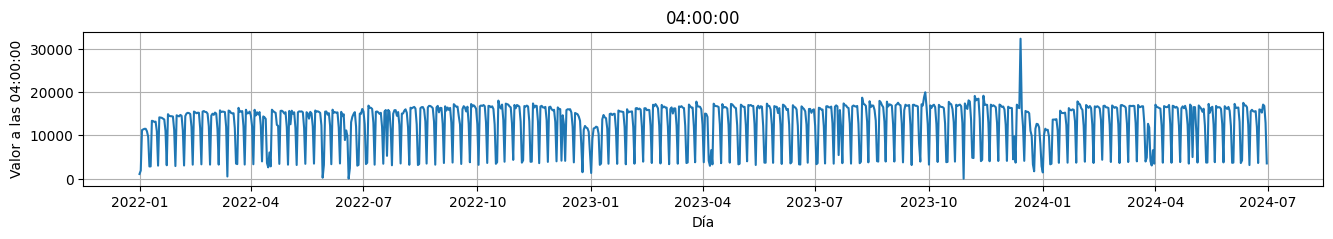

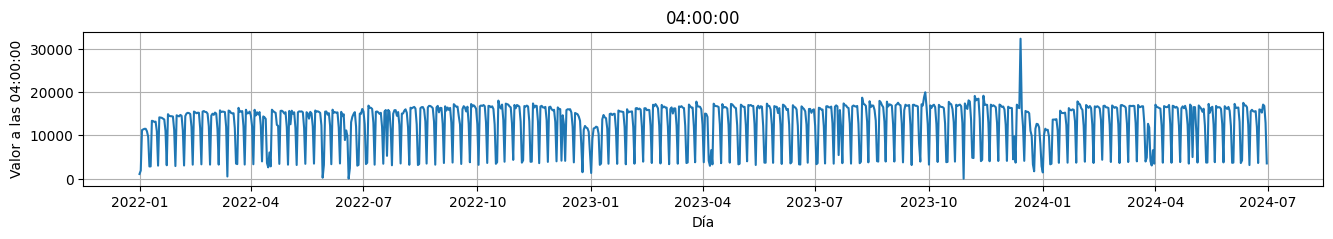

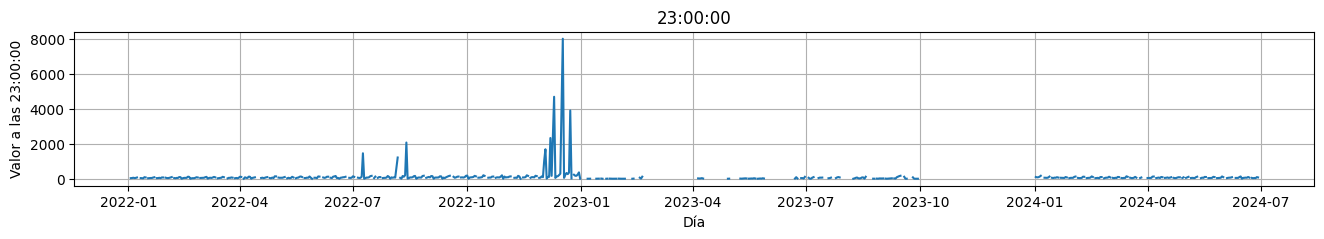

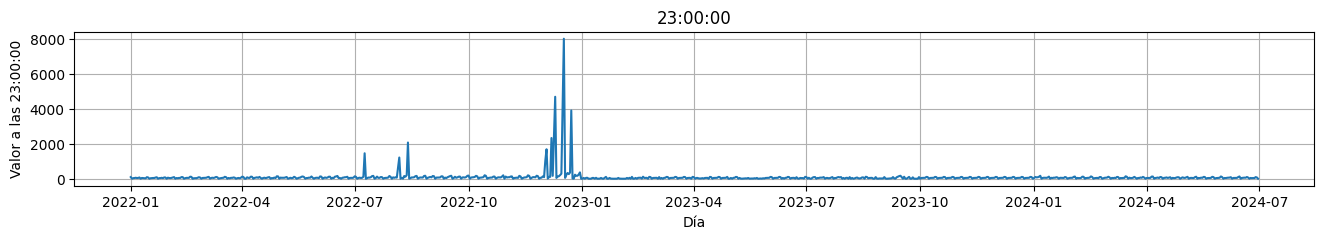

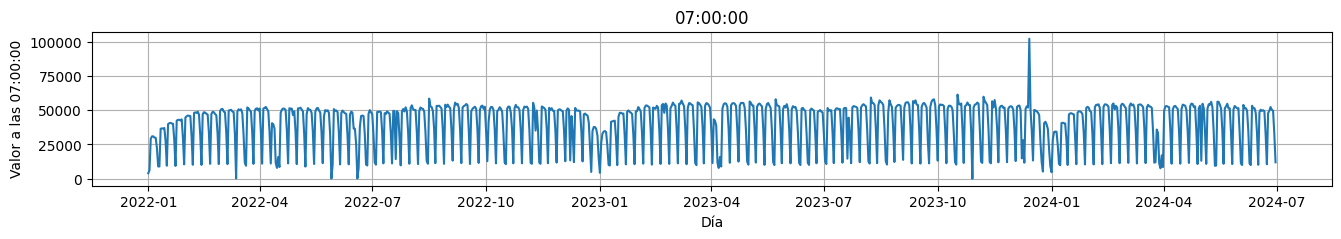

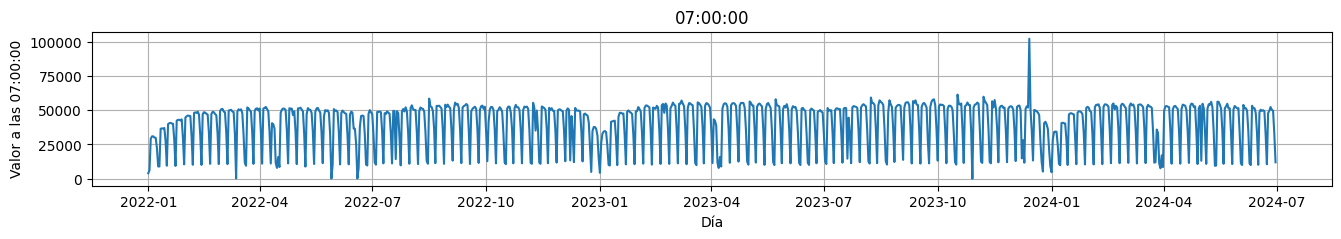

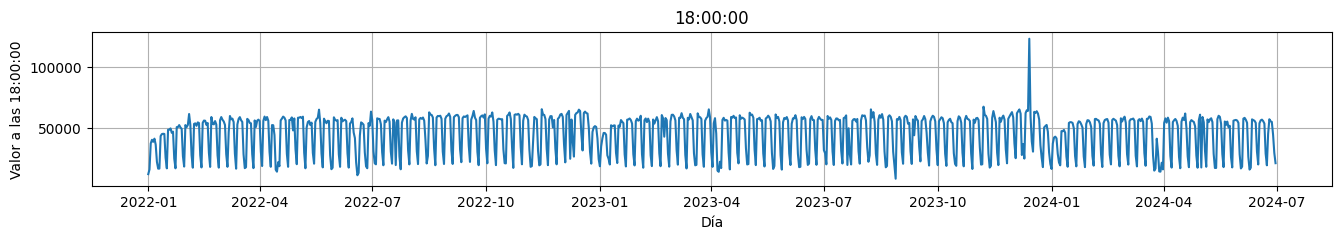

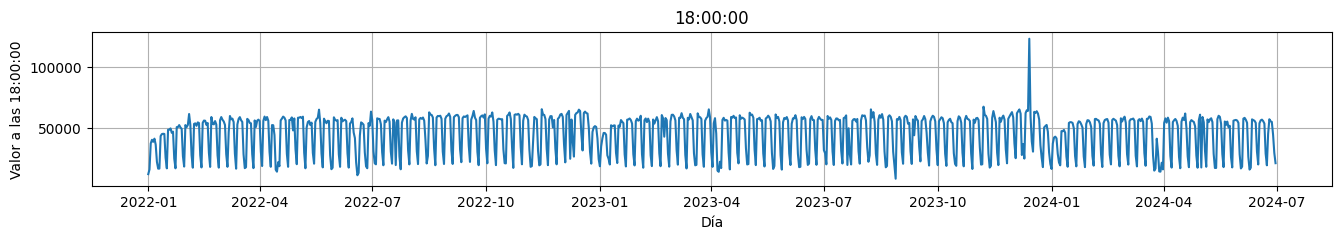

In [138]:
def plot_serie(df, hour, log_scale=False):
    plt.figure(figsize=(16, 2))
    plt.plot(df['Día'], df[hour])
    plt.title(hour)
    plt.xlabel('Día')
    plt.ylabel(f'Valor a las {hour}')
    if log_scale:
        plt.yscale('log')  # Aplica la escala logarítmica al eje y    
    plt.grid(True)
    plt.show()

hour = '04:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)    

hour = '23:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

hour = '07:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

hour = '18:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

In [139]:
# 6. Eliminar tendencia y estacionalidad
descomposiciones_agrupadas = eliminar_tendencia_estacionalidad(data_linea_a_full, horas)

Usando descomposición multiplicativa para 04:00:00
Usando descomposición multiplicativa para 05:00:00
Usando descomposición multiplicativa para 06:00:00
Usando descomposición multiplicativa para 07:00:00
Usando descomposición multiplicativa para 08:00:00
Usando descomposición multiplicativa para 09:00:00
Usando descomposición multiplicativa para 10:00:00
Usando descomposición multiplicativa para 11:00:00
Usando descomposición multiplicativa para 12:00:00
Usando descomposición multiplicativa para 13:00:00
Usando descomposición multiplicativa para 14:00:00
Usando descomposición multiplicativa para 15:00:00
Usando descomposición multiplicativa para 16:00:00
Usando descomposición multiplicativa para 17:00:00
Usando descomposición multiplicativa para 18:00:00
Usando descomposición multiplicativa para 19:00:00
Usando descomposición multiplicativa para 20:00:00
Usando descomposición multiplicativa para 21:00:00
Usando descomposición multiplicativa para 22:00:00
Usando descomposición multiplic

In [140]:
# 7. Detectar outliers en los residuos de la serie
outliers_residuos_agrupados = detectar_outliers_en_residuos(descomposiciones_agrupadas, umbral=3, data=data_linea_a_full)

# 8. Alinear los outliers con los datos originales
outliers_residuos_agrupados_aligned = data_linea_a_full[['Día']].merge(outliers_residuos_agrupados, on='Día', how='left').fillna(0)
outliers_residuos_agrupados_aligned_all = data_linea_a_full.merge(outliers_residuos_agrupados.add_suffix('_outlier'), on='Día', how='left').fillna(0)

outliers_residuos_agrupados_aligned_all.to_excel('results/full_2019_2024_data_linea_A_outliers.xlsx', index=False)

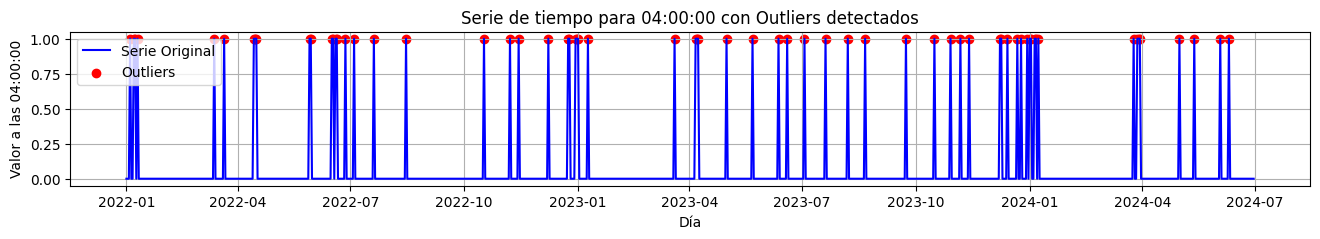

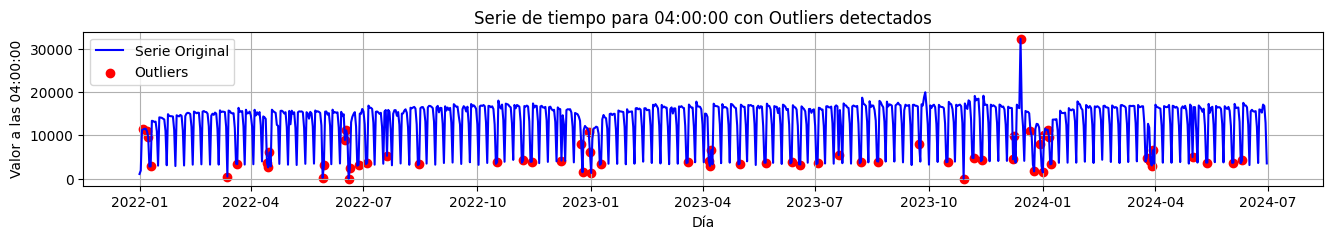

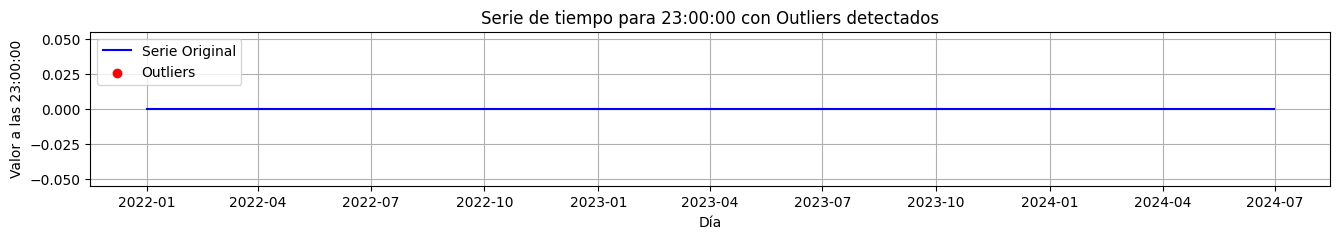

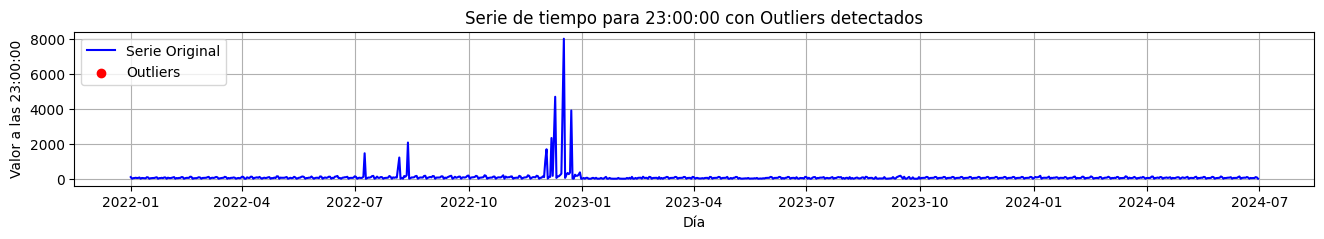

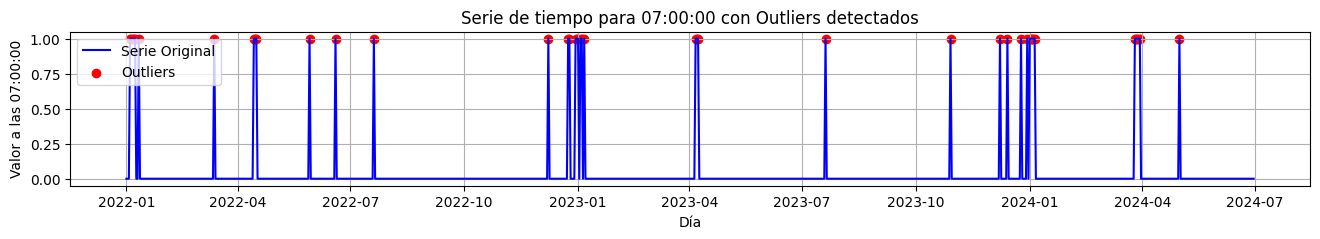

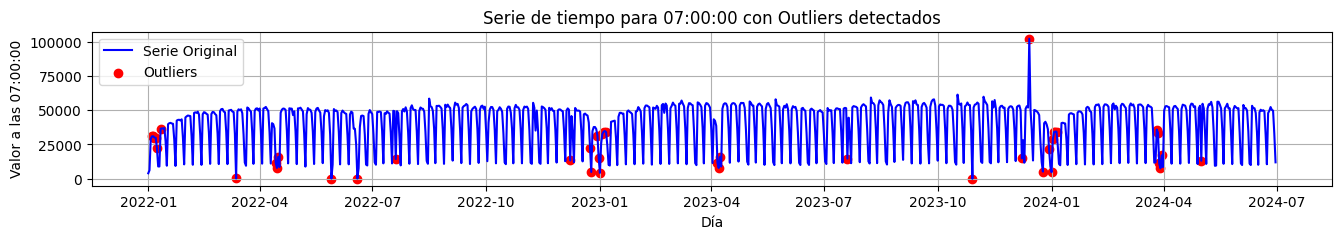

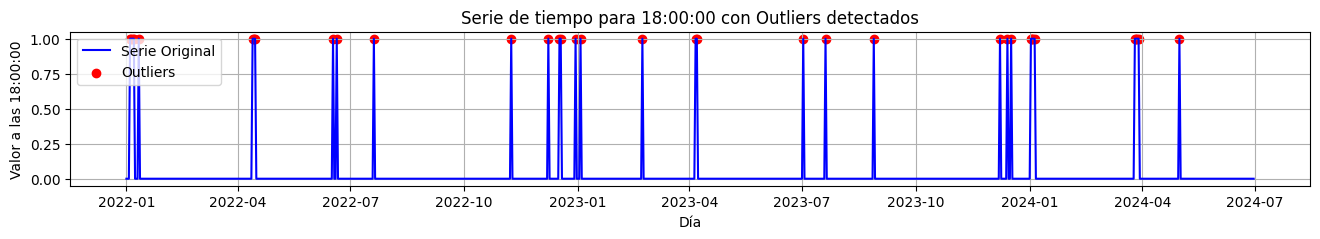

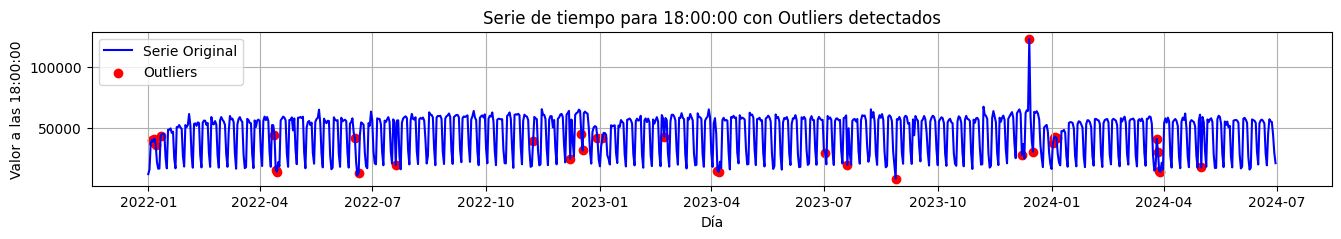

In [141]:
def plot_serie_con_outliers(df, hora, outliers_residuos):
    plt.figure(figsize=(16, 2))
    plt.plot(df['Día'], df[hora], label='Serie Original', color='blue')
    outliers = outliers_residuos[hora] == 1
    plt.scatter(df['Día'][outliers], df[hora][outliers], color='red', label='Outliers')
    plt.title(f'Serie de tiempo para {hora} con Outliers detectados')
    plt.xlabel('Día')
    plt.ylabel(f'Valor a las {hora}')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

hour = '04:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '23:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '07:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '18:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

Any_Outlier_outlier
0.0                    764
1.0                    148
Name: count, dtype: int64

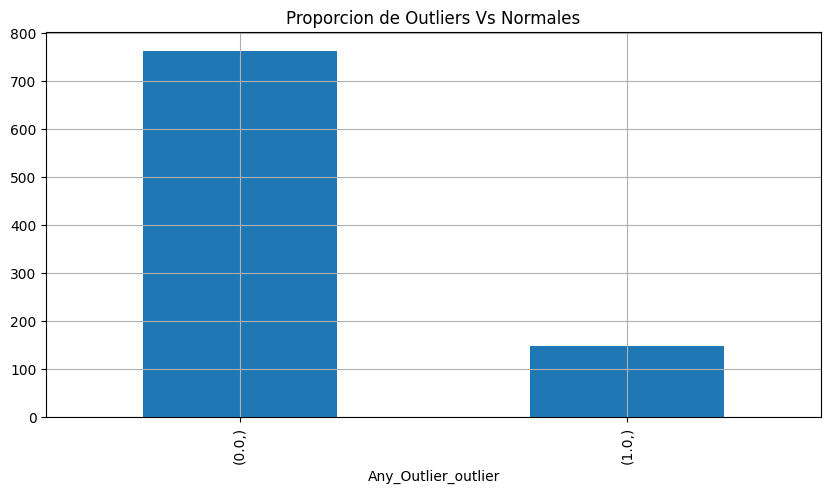

In [142]:
outliers_residuos_agrupados_aligned_all[['Any_Outlier_outlier']].value_counts().plot(kind='bar', grid=True, figsize=(10,5), title="Proporcion de Outliers Vs Normales")
outliers_residuos_agrupados_aligned_all[['Any_Outlier_outlier']].value_counts()

In [143]:
# 9. Preparar los datos para el LSTM Autoencoder
# Convertir los datos en matrices de 3 dimensiones: (samples, timesteps, features)
# En este caso, consideramos cada día como una secuencia de 20 pasos de tiempo (horas) con 1 feature (afluencia)

outlier_col = "Any_Outlier_outlier"
df_train = outliers_residuos_agrupados_aligned_all.copy()
df_train.loc[df_train[outlier_col] == 1, horas] = pd.NA
promedio_estacional = df_train.groupby('Día de la Semana')[horas].median()
df_train = rellenar_faltantes(df_train, promedio_estacional, horas)

df_test = outliers_residuos_agrupados_aligned_all[outliers_residuos_agrupados_aligned_all[outlier_col] == 1].copy()

# Crear datos de entrenamiento
X_train = df_train[horas].values  # shape: (n_días, n_horas)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # shape: (n_días, n_horas, 1)

# Crear datos de prueba
X_test = df_test[horas].values  # shape: (n_días_outlier, n_horas)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # shape: (n_días_outlier, n_horas, 1)

# 10. Normalizar los datos
scaler = MinMaxScaler()

# Ajustar el escalador solo con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# Transformar los datos de prueba
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Verificamos el tamaño de los conjuntos escalados
print(f"Train size (normal only, scaled): {X_train_scaled.shape}")
print(f"Test size (outliers and normal, scaled): {X_test_scaled.shape}")

Train size (normal only, scaled): (912, 20, 1)
Test size (outliers and normal, scaled): (148, 20, 1)


C:\Users\SEBASTIAN\AppData\Local\Temp\ipykernel_4376\2454340601.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Línea de Servicio'] = data['Línea de Servicio'].fillna(method='ffill')


In [144]:
# 11. Entrenar el autoencoder
autoencoder, history = entrenar_autoencoder(X_train_scaled)

Epoch 1/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 690ms/step - loss: 0.2859 - val_loss: 0.1860
Epoch 2/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.1885 - val_loss: 0.1749
Epoch 3/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.1686 - val_loss: 0.1550
Epoch 4/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.1592 - val_loss: 0.1527
Epoch 5/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.1548 - val_loss: 0.1532
Epoch 6/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.1539 - val_loss: 0.1455
Epoch 7/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.1471 - val_loss: 0.1378
Epoch 8/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.1394 - val_loss: 0.1340
Epoch 9/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.1335 - val_loss: 0.1258
Epoch 10/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.1335 - val_loss: 0.1333
Epoch 11/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.1318 - val_loss: 0.1217
Epoch 12/512
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.

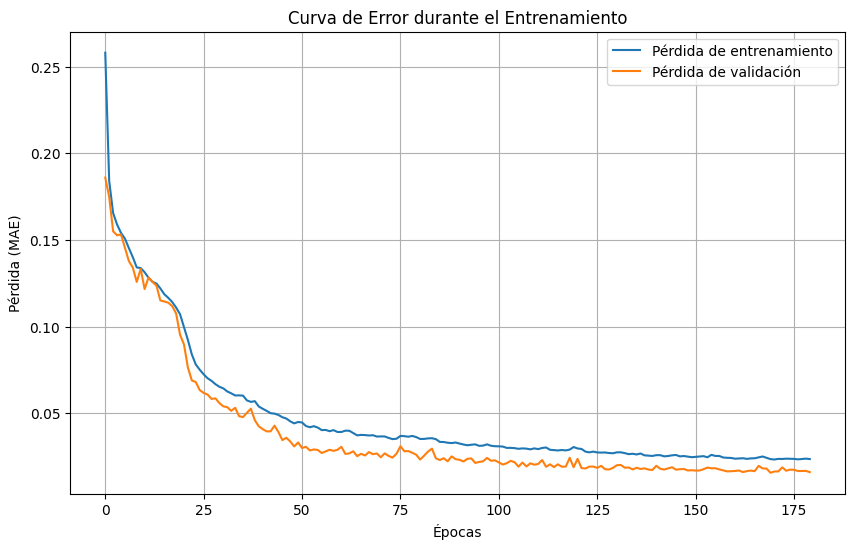

In [145]:
# 12. Graficar la curva de error durante el entrenamiento
graficar_curva_entrenamiento(history)

In [146]:
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 20, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 20, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 20, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 743,813 (2.84 MB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 495,876 (1.89 MB)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
El Umbral es: 0.0222124604072869
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


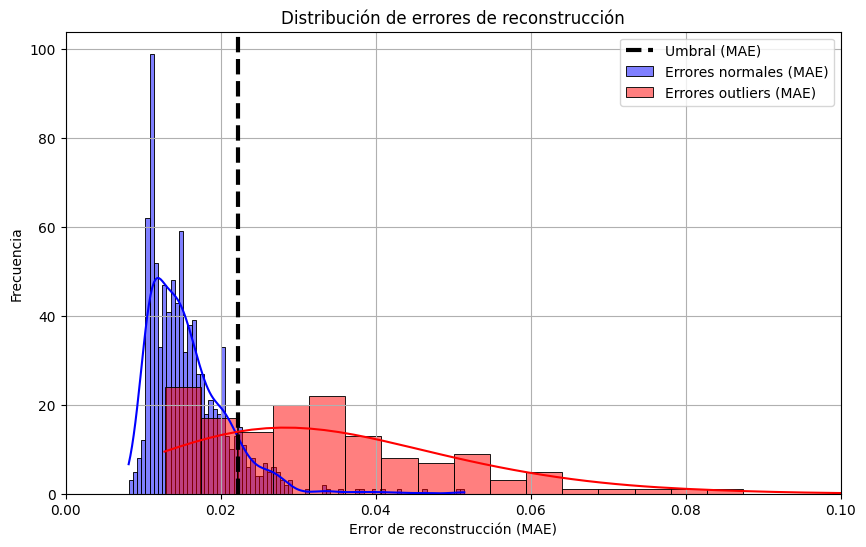

In [147]:
# 11. Calcular el umbral de detección de anomalías
# Obtener los errores de reconstrucción en los datos de entrenamiento
X_train_pred = autoencoder.predict(X_train_scaled)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train_scaled), axis=(1,2))

# Establecer el umbral (por ejemplo, percentil 90 de los errores de entrenamiento)
umbral_mae = np.percentile(train_mae_loss, 90)

print(f"El Umbral es: {umbral_mae}")

# 12. Evaluar el modelo en los datos de prueba
# Datos normales (para comparación)
X_normal_pred = autoencoder.predict(X_train_scaled)
normal_mae_loss = np.mean(np.abs(X_normal_pred - X_train_scaled), axis=(1,2))

# Datos con outliers
X_outliers_pred = autoencoder.predict(X_test_scaled)
outliers_mae_loss = np.mean(np.abs(X_outliers_pred - X_test_scaled), axis=(1,2))

# 13. Graficar las distribuciones de errores
plt.figure(figsize=(10,6))
sns.histplot(normal_mae_loss, bins=80, color='blue', kde=True, label='Errores normales (MAE)')
sns.histplot(outliers_mae_loss, bins=80, color='red', kde=True, label='Errores outliers (MAE)')
plt.axvline(umbral_mae, color='black', linestyle='--', label='Umbral (MAE)', lw=3)
plt.title('Distribución de errores de reconstrucción')
plt.xlabel('Error de reconstrucción (MAE)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.xlim([0,0.1])
plt.show()

Número de anomalías detectadas en datos normales: 92
Número de anomalías detectadas en datos con outliers: 106


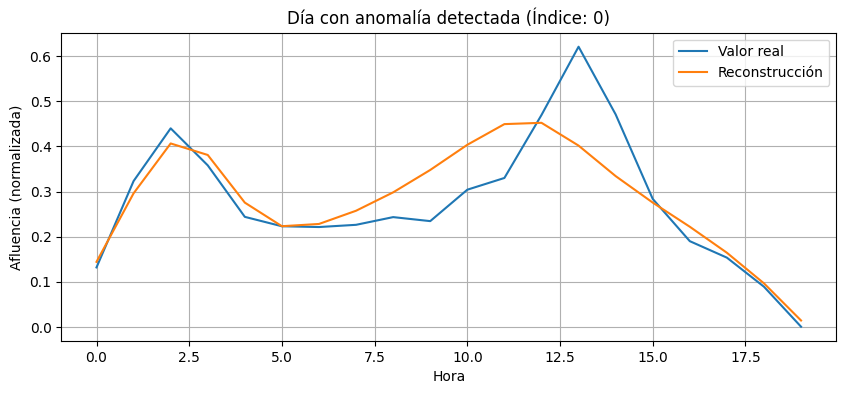

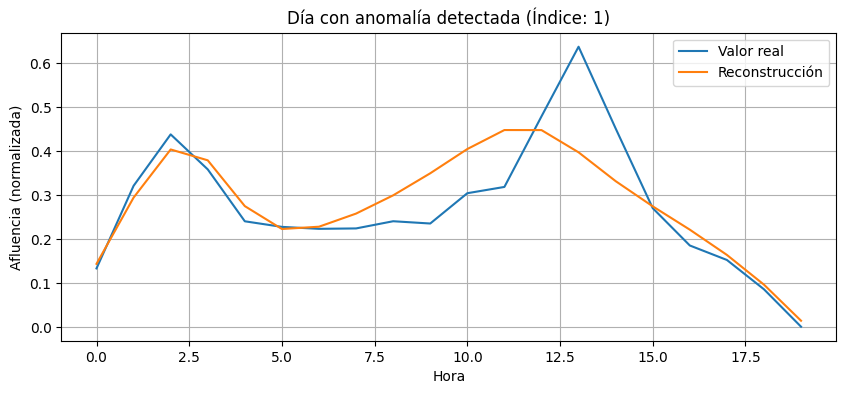

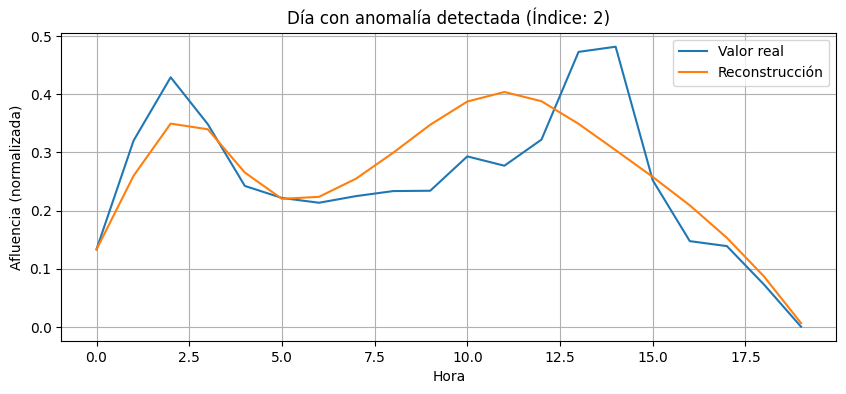

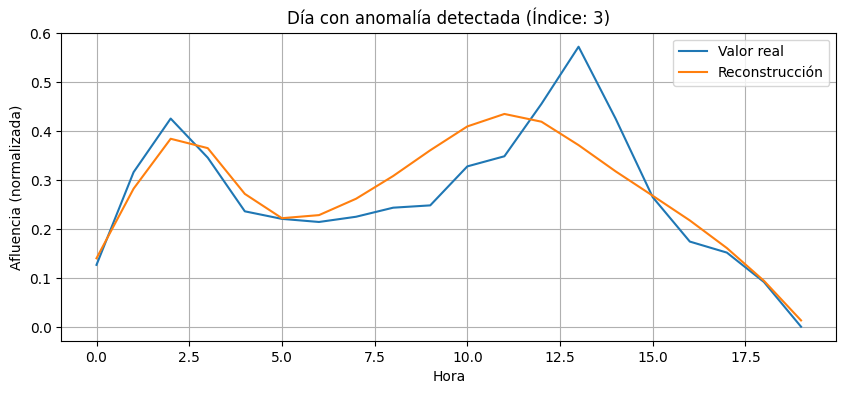

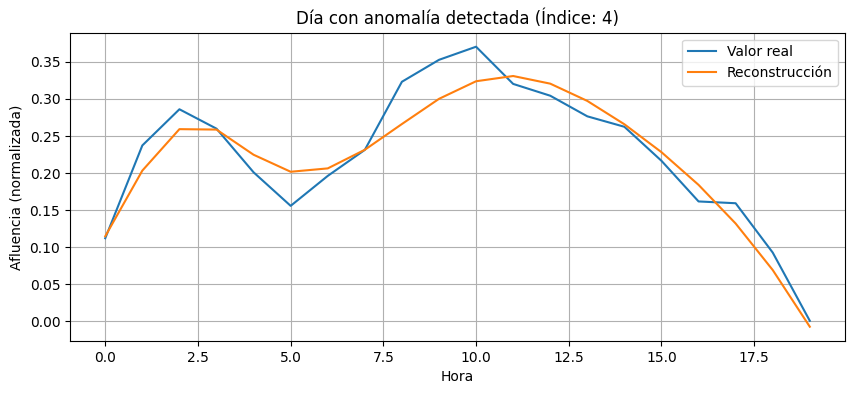

In [148]:
# 14. Detección de anomalías
# Datos normales
anomalies_normal = normal_mae_loss > umbral_mae
print(f'Número de anomalías detectadas en datos normales: {np.sum(anomalies_normal)}')

# Datos con outliers
anomalies_outliers = outliers_mae_loss > umbral_mae
print(f'Número de anomalías detectadas en datos con outliers: {np.sum(anomalies_outliers)}')

# 15. Visualizar algunos ejemplos
# Seleccionar algunos índices de los datos de prueba con errores altos
outlier_indices = np.where(anomalies_outliers)[0]

# Si hay anomalías detectadas, graficar algunas
if len(outlier_indices) > 0:
    for idx in outlier_indices[:5]:  # Mostrar hasta 5 ejemplos
        plt.figure(figsize=(10,4))
        plt.plot(X_test_scaled[idx], label='Valor real')
        plt.plot(X_outliers_pred[idx], label='Reconstrucción')
        plt.title(f'Día con anomalía detectada (Índice: {idx})')
        plt.xlabel('Hora')
        plt.ylabel('Afluencia (normalizada)')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("No se detectaron anomalías en los datos de prueba.")

Métricas de desempeño del modelo:
Precisión: 0.5354
Recall: 0.7162
F1-score: 0.6127
Exactitud: 0.8736


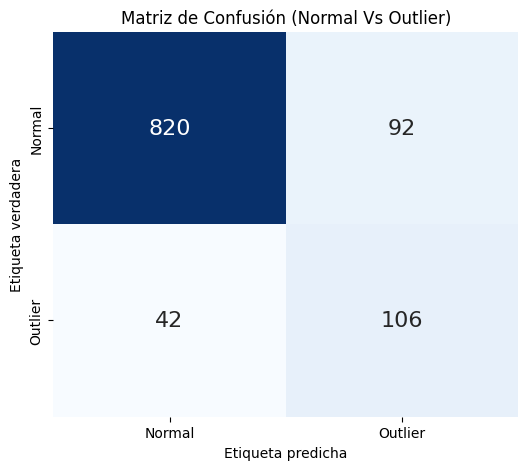

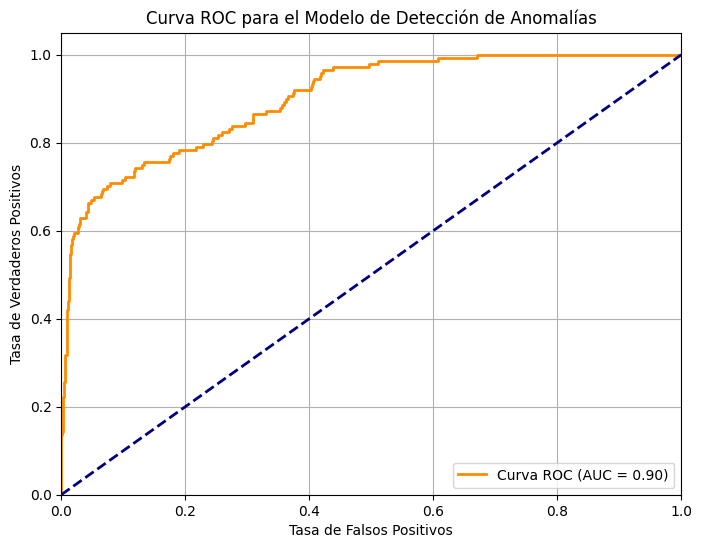

In [150]:
# 13. Calcular las métricas de desempeño
metricas = calcular_metricas(normal_mae_loss, outliers_mae_loss, umbral_mae)

# Imprimir las métricas
print("Métricas de desempeño del modelo:")
print(f"Precisión: {metricas['precision']:.4f}")
print(f"Recall: {metricas['recall']:.4f}")
print(f"F1-score: {metricas['f1_score']:.4f}")
print(f"Exactitud: {metricas['accuracy']:.4f}")

# Imprimir la matriz de confusión
labels = ['Normal', 'Outlier']
df_cm = pd.DataFrame(metricas['confusion_matrix'], index=labels, columns=labels)
plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size':16})
plt.title("Matriz de Confusión (Normal Vs Outlier)")
plt.ylabel("Etiqueta verdadera")
plt.xlabel("Etiqueta predicha")
plt.show()

# Llamar a la función
plot_roc_curve(normal_mae_loss, outliers_mae_loss)

# FIN
---